# CS 7641 - HW3 Unsupervised Learning and Dimensionality Reduction (Airline)


You are to implement (or find the code for) six algorithms. 

The first two are clustering algorithms:

- k-means clustering
- Expectation Maximization

You can choose your own measures of distance/similarity. Naturally, you'll have to justify your choices, but you're practiced at that sort of thing by now.

The last four algorithms are dimensionality reduction algorithms:

- PCA
- ICA
- Randomized Projections
- Any other feature selection algorithm you desire
You are to run a number of experiments. Come up with at least two datasets. If you'd like (and it makes a lot of sense in this case) you can use the ones you used in the first assignment.

1. Run the clustering algorithms on the datasets and describe what you see.
2. Apply the dimensionality reduction algorithms to the two datasets and describe what you see.
3. Reproduce your clustering experiments, but on the data after you've run dimensionality reduction on it. Yes, that’s 16 combinations of datasets, dimensionality reduction, and clustering method. You should look at all of them, but focus on the more interesting findings in your report.
4. Apply the dimensionality reduction algorithms to one of your datasets from assignment #1 (if you've reused the datasets from assignment #1 to do experiments 1-3 above then you've already done this) and rerun your neural network learner on the newly projected data.
5. Apply the clustering algorithms to the same dataset to which you just applied the dimensionality reduction algorithms (you've probably already done this), treating the clusters as if they were new features. In other words, treat the clustering algorithms as if they were dimensionality reduction algorithms. Again, rerun your neural network learner on the newly projected data.


- a discussion of your datasets, and why they're interesting: If you're using the same datasets as before at least briefly remind us of what they are so we don't have to revisit your old assignment write-up... and if you aren't well that's a whole lot of work you're going to have to recreate from assignment 1 isn't it?
- explanations of your methods: for example, how did you choose k?
- a description of the kind of clusters that you got.
- analyses of your results. Why did you get the clusters you did? Do they make "sense"? If you used data that already had labels (for example data from a classification problem from assignment #1) did the clusters line up with the labels? Do they otherwise line up naturally? Why or why not? Compare and contrast the different algorithms. What sort of changes might you make to each of those algorithms to improve performance? How much performance was due to the problems you chose? Be creative and think of as many questions you can, and as many answers as you can. Take care to justify your analysis with data explicitly.
- Can you describe how the data look in the new spaces you created with the various algorithms? For PCA, what is the distribution of eigenvalues? For ICA, how kurtotic are the distributions? Do the projection axes for ICA seem to capture anything "meaningful"? Assuming you only generate k projections (i.e., you do dimensionality reduction), how well is the data reconstructed by the randomized projections? PCA? How much variation did you get when you re-ran your RP several times (I know I don't have to mention that you might want to run RP many times to see what happens, but I hope you forgive me)?
- When you reproduced your clustering experiments on the datasets projected onto the new spaces created by ICA, PCA, and RP, did you get the same clusters as before? Different clusters? Why? Why not?
- When you re-ran your neural network algorithms were there any differences in performance? Speed? Anything at all?

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


from sklearn.cluster import KMeans

from sklearn.decomposition import PCA


In [97]:
airline_train = pd.read_csv('Data/AirlinePassengerSatisfaction/train.csv')
airline_test = pd.read_csv('Data/AirlinePassengerSatisfaction/test.csv')
airline = pd.concat([airline_train, airline_test])
airline = airline.sample(frac =.2)


In [98]:
le = LabelEncoder()
airline.satisfaction = le.fit_transform(airline.satisfaction)
airline.Gender = le.fit_transform(airline.Gender)
airline['Customer Type'] = le.fit_transform(airline['Customer Type'])
airline['Type of Travel'] = le.fit_transform(airline['Type of Travel'])

le_class = LabelEncoder()
le_class = le_class.fit(airline['Class'])
le_class.classes_ = np.array(['Eco','Eco Plus', 'Business'])
airline['Class'] = le_class.transform(airline['Class'])


In [99]:
airline.columns

Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

In [100]:
X

Gender  Customer Type  Age  Type of Travel  Class  \
15178       0              0   51               0      2   
10170       1              1   38               0      0   
72721       1              1   35               0      2   
25443       1              0   40               0      2   
96631       0              0    8               1      0   
...       ...            ...  ...             ...    ...   
90121       0              0   26               0      2   
86289       0              0   10               1      0   
90040       0              0   42               0      0   
63701       1              0   44               0      2   
32553       1              0   32               1      0   

       Inflight wifi service  Departure/Arrival time convenient  \
15178                      5                                  5   
10170                      4                                  3   
72721                      1                                  1   
25443                      3                                  3   
96631                      2                                  5   
...                      ...                                ...   
90121                      5                                  5   
86289                      4                                  4   
90040                      4                                  1   
63701                      4                                  4   
32553                      2                                  5   

       Ease of Online booking  Gate location  Food and drink  Online boarding  \
15178                       5              5               3                5   
10170                       4              3               3                4   
72721                       1              3               4                1   
25443                       3              3               4                4   
96631                       2              2               4                2   
...                       ...            ...             ...              ...   
90121                       5              5               5                5   
86289                       4              4               2                4   
90040                       1              1               4                4   
63701                       4              4               5                4   
32553                       2              3               1                2   

       Seat comfort  Inflight entertainment  On-board service  \
15178             4                       4                 4   
10170             3                       3                 1   
72721             4                       4                 4   
25443             4                       5                 5   
96631             5                       4                 3   
...             ...                     ...               ...   
90121             5                       5                 4   
86289             2                       2                 3   
90040             4                       4                 4   
63701             5                       4                 4   
32553             1                       1                 4   

       Leg room service  Baggage handling  Checkin service  Inflight service  \
15178                 5                 4                5                 4   
10170                 3                 3                2                 5   
72721                 4                 5                4                 4   
25443                 5                 5                5                 5   
96631                 2                 4                3                 5   
...                 ...               ...              ...               ...   
90121                 2                 5                5                 5   
86289                 4                 4                3                 4   
90040  

In [101]:
feature_cols = [ 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes']

X = airline[feature_cols]
y = airline.satisfaction
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


(array([  453.,     0.,     0.,     0.,     0., 22831.,     0.,     0.,
            0.,  2692.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

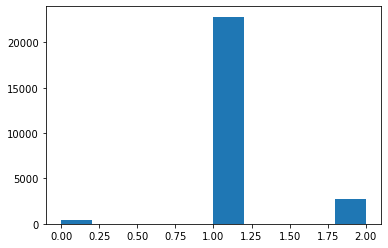

In [102]:
from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(X)

plt.hist(y_km)

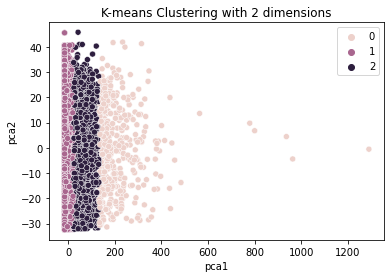

In [103]:
### Run PCA on the data and reduce the dimensions in pca_num_components dimensions
import seaborn as sns

pca_num_components = 2
reduced_data = PCA(n_components=pca_num_components).fit_transform(X)
results = pd.DataFrame(reduced_data, columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue = y_km, data=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.7753641338271099
For n_clusters = 3 The average silhouette_score is : 0.6448344891451643
For n_clusters = 4 The average silhouette_score is : 0.3990427341034185
For n_clusters = 5 The average silhouette_score is : 0.4128010052682188
For n_clusters = 6 The average silhouette_score is : 0.4162946426473765
For n_clusters = 7 The average silhouette_score is : 0.42177425360156623
For n_clusters = 8 The average silhouette_score is : 0.3457542830633203
For n_clusters = 9 The average silhouette_score is : 0.3454442337001931
For n_clusters = 10 The average silhouette_score is : 0.3534413189731911
For n_clusters = 11 The average silhouette_score is : 0.3536367228941245


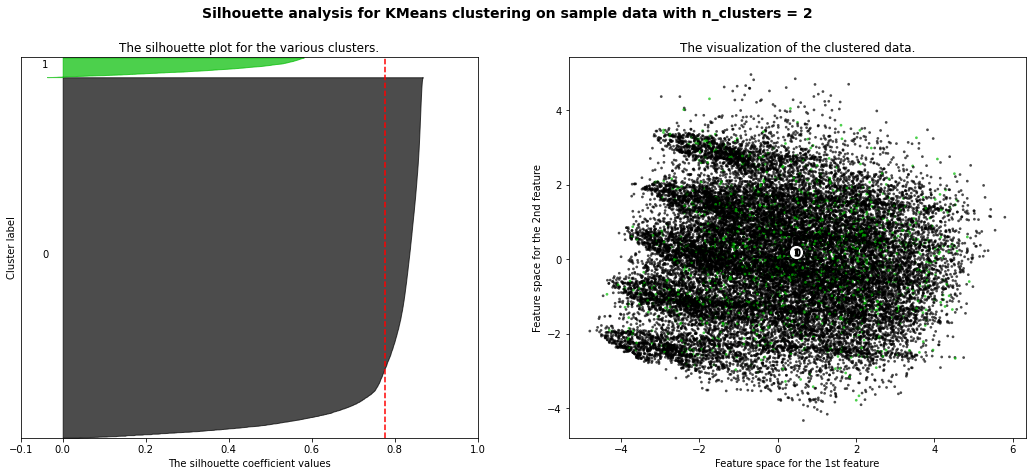

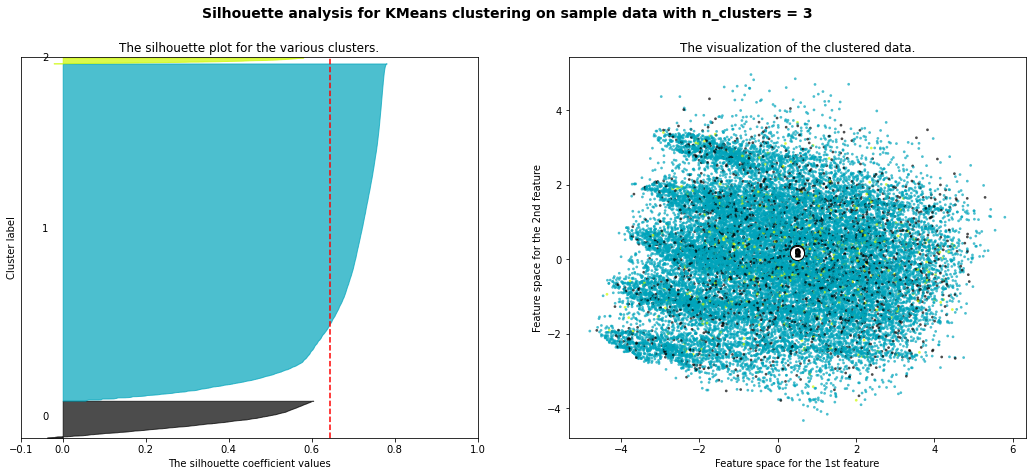

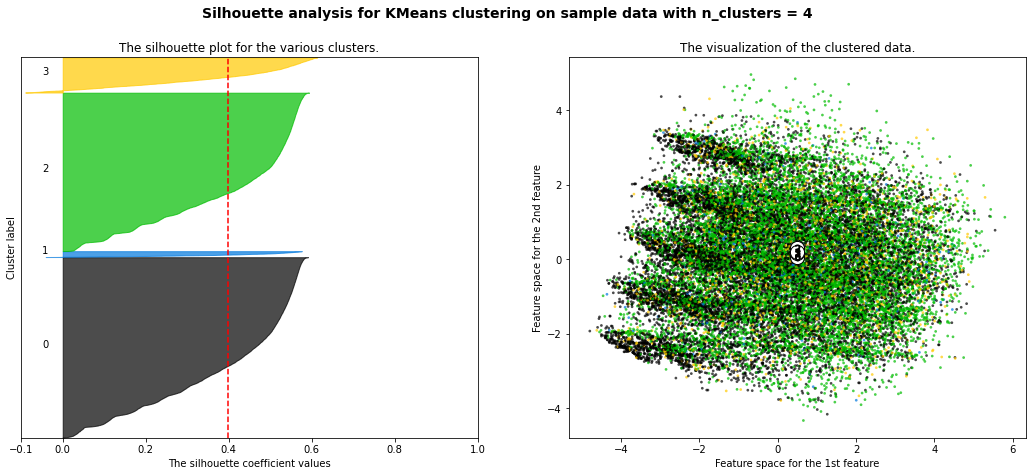

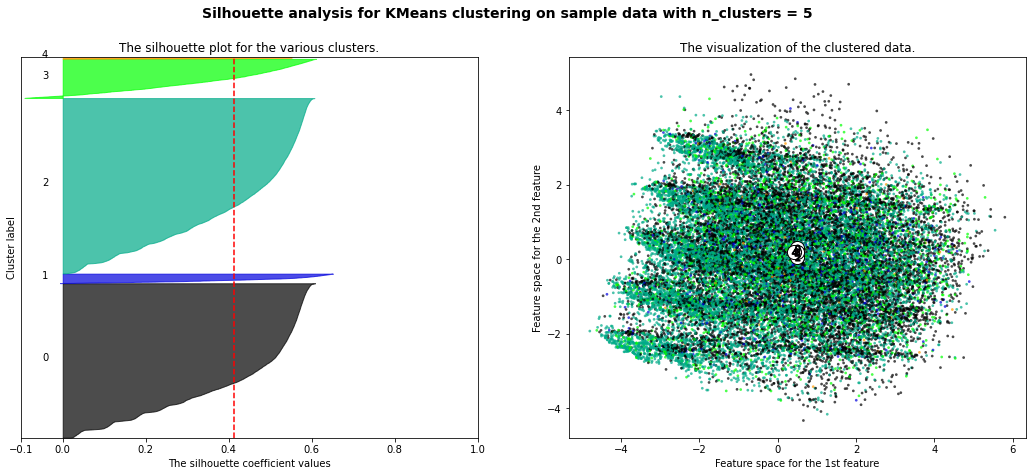

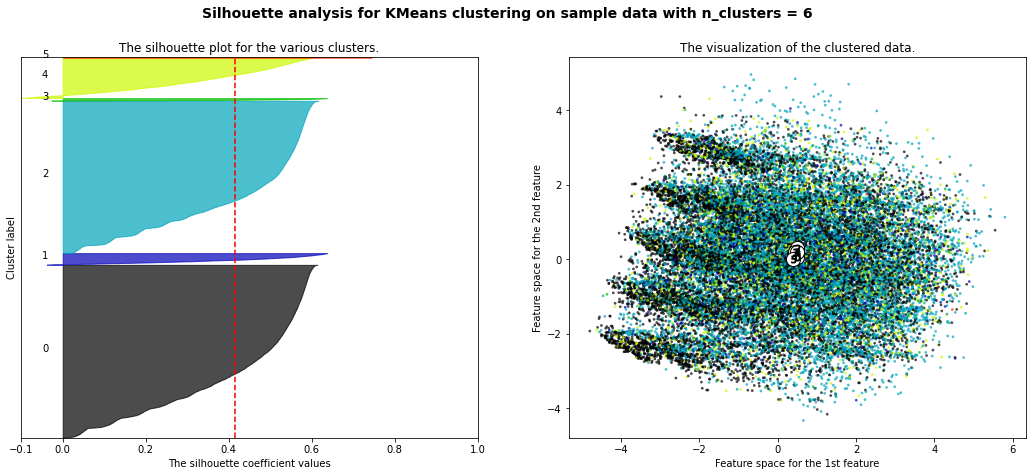

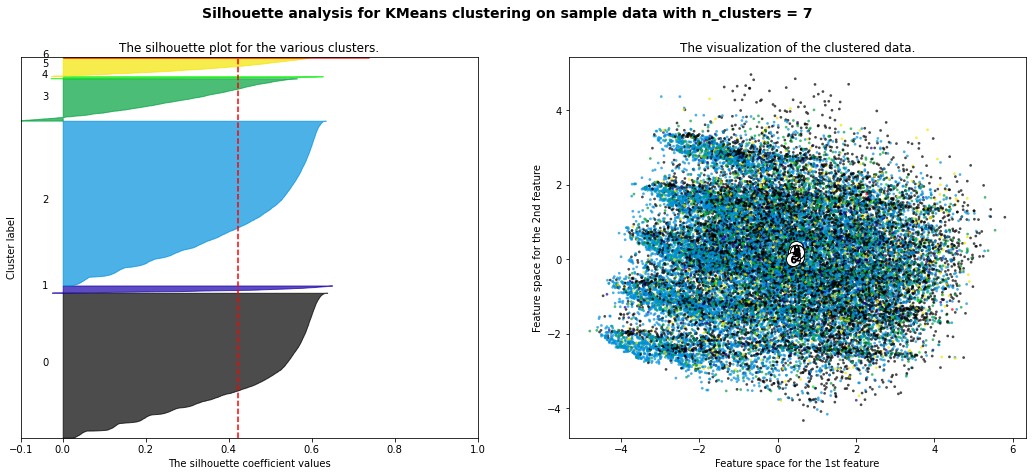

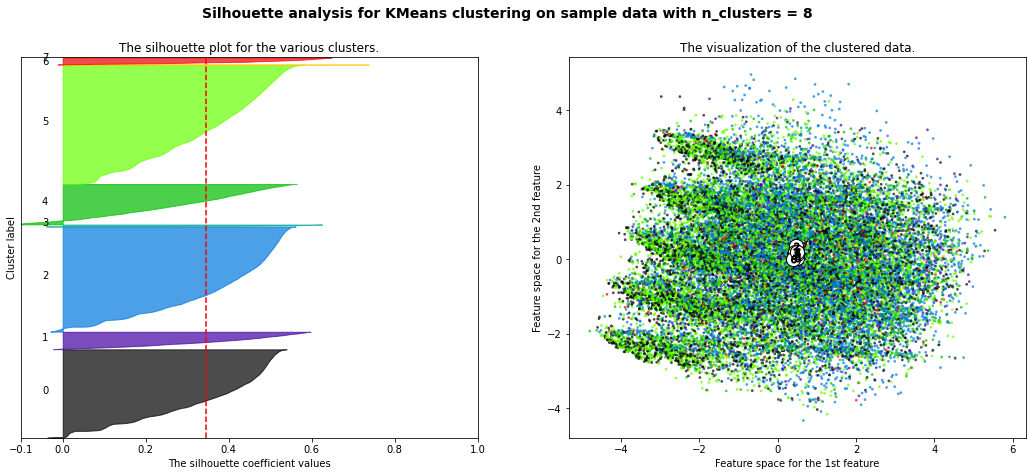

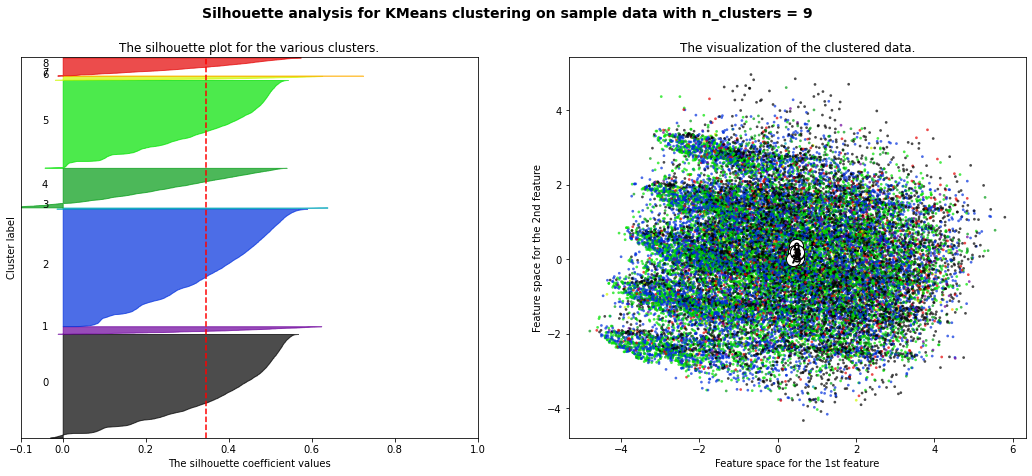

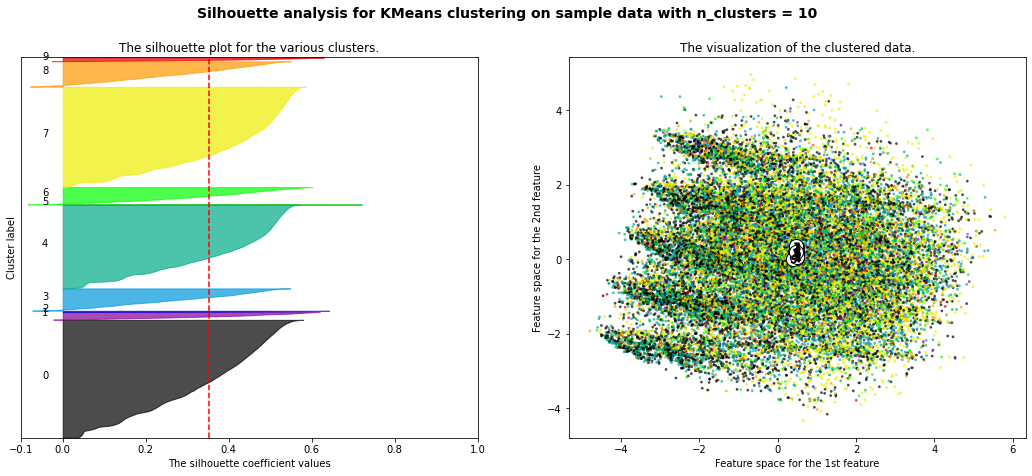

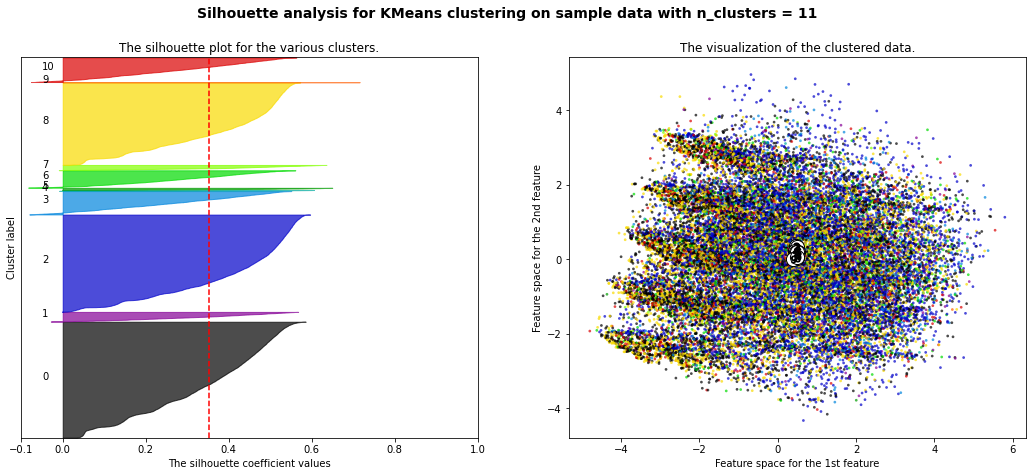

In [168]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

range_n_clusters = range(2,12)
distortions = []
km_silhouette = []
inertias = []
mapping1 = {}
mapping2 = {}

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    distortions.append(sum(np.min(cdist(X, clusterer.cluster_centers_,
                                    'euclidean'), axis=1)) / X.shape[0])
    inertias.append(clusterer.inertia_)  
    
    silhouette = silhouette_score(X, cluster_labels)
    km_silhouette.append(silhouette)
    
    mapping1[i] = sum(np.min(cdist(X, clusterer.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[i] = clusterer.inertia_
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        results.pca1, results.pca2, marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )
    
    
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

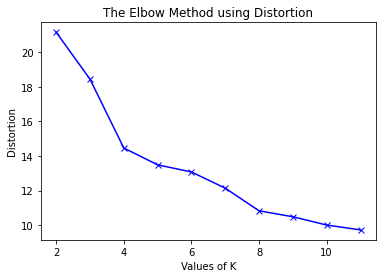

In [169]:
plt.plot(range_n_clusters, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

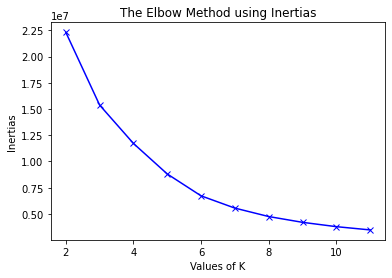

In [170]:
plt.plot(range_n_clusters, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertias')
plt.title('The Elbow Method using Inertias')
plt.show()

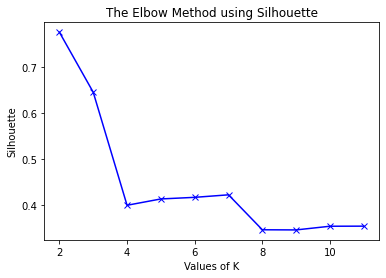

In [171]:
plt.plot(range_n_clusters, km_silhouette, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette')
plt.title('The Elbow Method using Silhouette')
plt.show()

In [114]:
# https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Clustering-Dimensionality-Reduction/Clustering_metrics.ipynb
from sklearn.mixture import GaussianMixture

gm_bic= []
gm_score=[]

for i in range(2,12):
    gm = GaussianMixture(n_components=i, n_init=10, tol=1e-3, max_iter=1000).fit(X)
    print("BIC for number of cluster(s) {}: {}".format(i, gm.bic(X)))
    print("Log-likelihood score for number of cluster(s) {}: {}".format(i,gm.score(X)))
    print("-"*100)
    gm_bic.append(-gm.bic(X))
    gm_score.append(gm.score(X))

BIC for number of cluster(s) 2: 1442211.375590799
Log-likelihood score for number of cluster(s) 2: -27.67025992527997
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 3: 826892.3243395822
Log-likelihood score for number of cluster(s) 3: -15.78107087208278
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 4: 756265.1653007376
Log-likelihood score for number of cluster(s) 4: -14.376403920294045
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 5: 587898.3922920488
Log-likelihood score for number of cluster(s) 5: -11.0903923817744
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 6: 437357.6759680947
Log-likelihood score for number of cluster(s) 6: -8.14750635689686
-------

In [117]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score,v_measure_score


scaler = MinMaxScaler()
X_scaled=scaler.fit_transform(X)

km_scores= []
km_silhouette = []
vmeasure_score =[]
db_score = []
for i in range(2,12):
    km = KMeans(n_clusters=i, random_state=0).fit(X_scaled)
    preds = km.predict(X_scaled)
    
    print("Score for number of cluster(s) {}: {}".format(i,km.score(X_scaled)))
    km_scores.append(-km.score(X_scaled))
    
    silhouette = silhouette_score(X_scaled,preds)
    km_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
    
    db = davies_bouldin_score(X_scaled,preds)
    db_score.append(db)
    print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))
    
    v_measure = v_measure_score(y,preds)
    vmeasure_score.append(v_measure)
    print("V-measure score for number of cluster(s) {}: {}".format(i,v_measure))
    print("-"*100)

Score for number of cluster(s) 2: -41674.05639713498
Silhouette score for number of cluster(s) 2: 0.1685639665245353
Davies Bouldin score for number of cluster(s) 2: 2.1834283700467987
V-measure score for number of cluster(s) 2: 0.21319579749042317
----------------------------------------------------------------------------------------------------
Score for number of cluster(s) 3: -37042.17826156443
Silhouette score for number of cluster(s) 3: 0.1766162892388564
Davies Bouldin score for number of cluster(s) 3: 2.1875680669999586
V-measure score for number of cluster(s) 3: 0.2890052642867629
----------------------------------------------------------------------------------------------------
Score for number of cluster(s) 4: -33986.63751628291
Silhouette score for number of cluster(s) 4: 0.16214163661084724
Davies Bouldin score for number of cluster(s) 4: 1.9629950269329077
V-measure score for number of cluster(s) 4: 0.1976592842822721
----------------------------------------------------

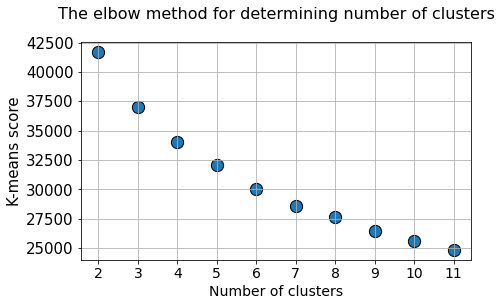

In [118]:
plt.figure(figsize=(7,4))
plt.title("The elbow method for determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=km_scores,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("K-means score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

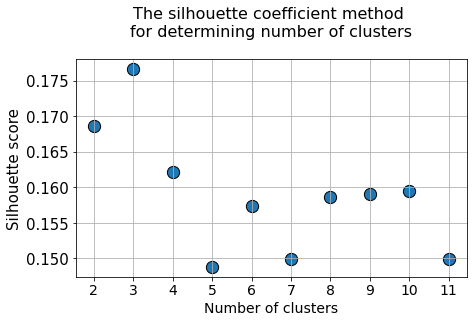

In [119]:
plt.figure(figsize=(7,4))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=km_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

In [120]:
from sklearn.mixture import GaussianMixture

gm_bic= []
gm_score=[]
for i in range(2,12):
    gm = GaussianMixture(n_components=i,n_init=10,tol=1e-3,max_iter=1000).fit(X_scaled)
    print("BIC for number of cluster(s) {}: {}".format(i,gm.bic(X_scaled)))
    print("Log-likelihood score for number of cluster(s) {}: {}".format(i,gm.score(X_scaled)))
    print("-"*100)
    gm_bic.append(-gm.bic(X_scaled))
    gm_score.append(gm.score(X_scaled))

BIC for number of cluster(s) 2: -442135.71613314864
Log-likelihood score for number of cluster(s) 2: 8.60066500011169
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 3: -709690.2127885364
Log-likelihood score for number of cluster(s) 3: 13.79589511821824
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 4: -995409.0709275391
Log-likelihood score for number of cluster(s) 4: 19.340762622443034
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 5: -1248245.5962630713
Log-likelihood score for number of cluster(s) 5: 24.25269332339807
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 6: -1389144.7923114975
Log-likelihood score for number of cluster(s) 6: 27.00999418744392
---

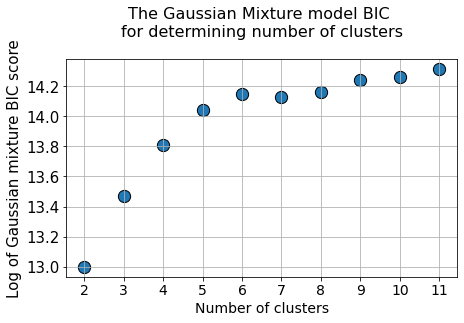

In [121]:
plt.figure(figsize=(7,4))
plt.title("The Gaussian Mixture model BIC \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=np.log(gm_bic),s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Log of Gaussian mixture BIC score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()


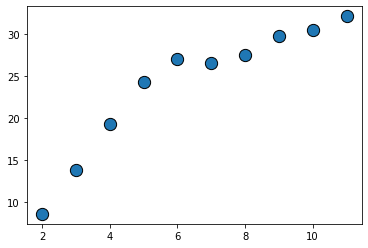

In [122]:
plt.scatter(x=[i for i in range(2,12)],y=gm_score,s=150,edgecolor='k')
plt.show()

# K-Means Clustering

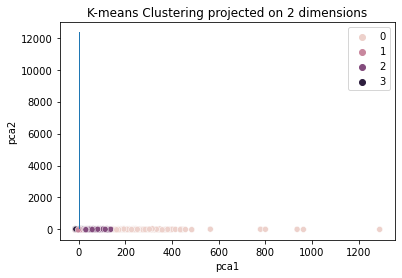

In [172]:

from sklearn.cluster import KMeans
import seaborn as sns


km = KMeans(n_clusters=4, init='random', n_init=10, max_iter=300,tol=1e-04, random_state=0)
y_km = km.fit_predict(X)

plt.hist(y_km)

### Run PCA on the data and reduce the dimensions in pca_num_components dimensions

pca_num_components = 2
reduced_data = PCA(n_components=pca_num_components).fit_transform(X)
results = pd.DataFrame(reduced_data, columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue = y_km, data=results)
plt.title('K-means Clustering projected on 2 dimensions')
plt.show()

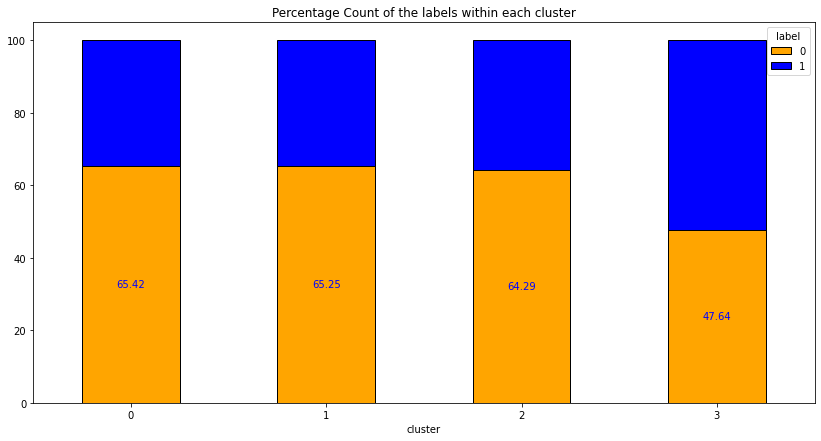

In [175]:
km_cluster_label = pd.DataFrame({'cluster':y_km, 'label':y.values})
km_cluster_label['cnt'] = 1

df=km_cluster_label.groupby(['cluster','label']).size().groupby(level=0).apply(lambda x: round(100*x/x.sum(),2))
df=df.unstack()
ax= df.plot(
    kind='bar',
    stacked=True,
    figsize=(14,7),
    rot=0,
    title='Percentage Count of the labels within each cluster',
    color=['orange','blue'],
    edgecolor='black',
    
)
for c in ax.containers:
    ax.bar_label(c, label_type='center',color='b')

# Expectation Maximization

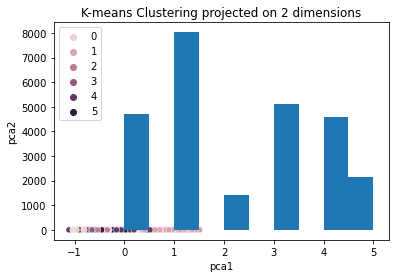

In [178]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=6).fit(X_scaled)
y_gm = gm.fit_predict(X_scaled)

plt.hist(y_gm)



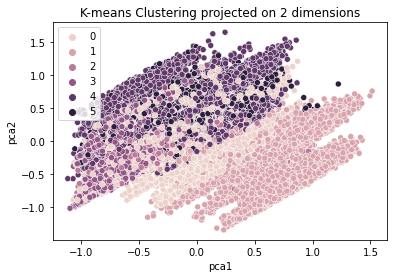

In [180]:
### Run PCA on the data and reduce the dimensions in pca_num_components dimensions
pca_num_components = 2
reduced_data = PCA(n_components=pca_num_components).fit_transform(X_scaled)
results = pd.DataFrame(reduced_data, columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue = y_gm, data=results)
plt.title('K-means Clustering projected on 2 dimensions')
plt.show()

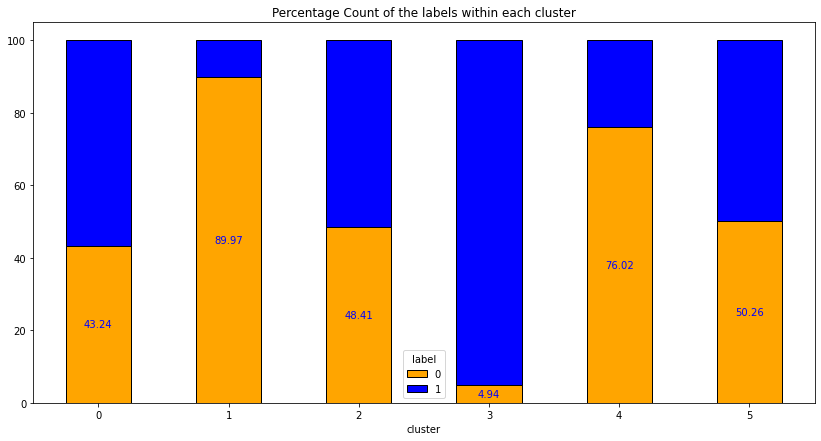

In [181]:
gm_cluster_label = pd.DataFrame({'cluster':y_gm, 'label':y.values})
gm_cluster_label['cnt'] = 1
df=gm_cluster_label.groupby(['cluster','label']).size().groupby(level=0).apply(lambda x: round(100*x/x.sum(),2))
df=df.unstack()
ax= df.plot(
    kind='bar',
    stacked=True,
    figsize=(14,7),
    rot=0,
    title='Percentage Count of the labels within each cluster',
    color=['orange','blue'],
    edgecolor='black',
    
)
for c in ax.containers:
    ax.bar_label(c, label_type='center',color='b')

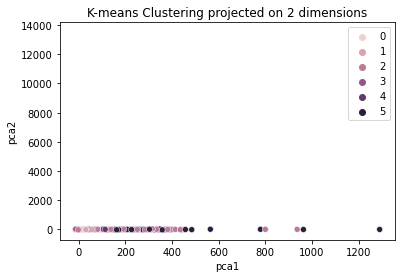

In [182]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=6).fit(X)
y_gm = gm.fit_predict(X)

plt.hist(y_gm)

### Run PCA on the data and reduce the dimensions in pca_num_components dimensions
pca_num_components = 2
reduced_data = PCA(n_components=pca_num_components).fit_transform(X)
results = pd.DataFrame(reduced_data, columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue = y_gm, data=results)
plt.title('K-means Clustering projected on 2 dimensions')
plt.show()

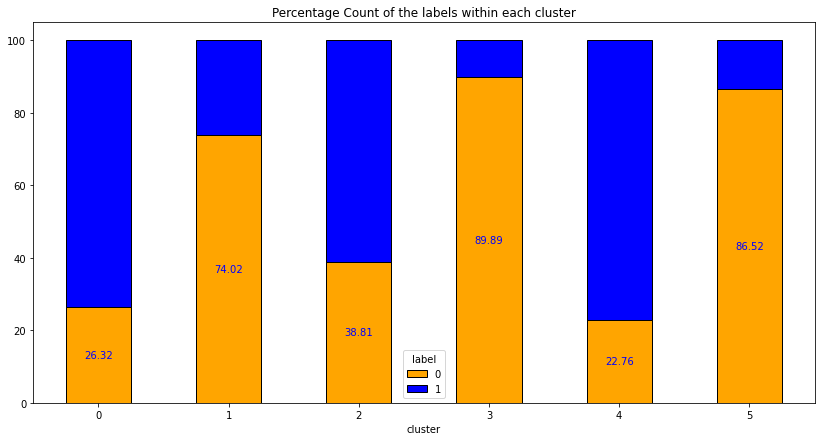

In [183]:
gm_cluster_label = pd.DataFrame({'cluster':y_gm, 'label':y.values})
gm_cluster_label['cnt'] = 1
df=gm_cluster_label.groupby(['cluster','label']).size().groupby(level=0).apply(lambda x: round(100*x/x.sum(),2))
df=df.unstack()
ax= df.plot(
    kind='bar',
    stacked=True,
    figsize=(14,7),
    rot=0,
    title='Percentage Count of the labels within each cluster',
    color=['orange','blue'],
    edgecolor='black',
    
)
for c in ax.containers:
    ax.bar_label(c, label_type='center',color='b')

# PCA

In [152]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

sc = StandardScaler()
X_std = sc.fit_transform(X)
cov_mat = np.cov(X_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)


# calculate cumulative sum of explained variances
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

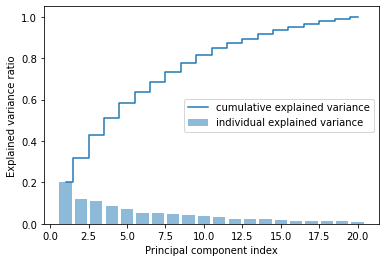

In [156]:
# plot explained variances
plt.bar(range(1,len(var_exp) + 1), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1,len(var_exp) + 1), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [187]:
eigen_vals

array([4.002369  , 2.3762712 , 2.20161938, 1.68430807, 1.40505377,
       1.01655892, 1.00540478, 0.95106133, 0.87952924, 0.73404728,
       0.67628315, 0.17569876, 0.48557074, 0.46108772, 0.42575094,
       0.36771049, 0.2492171 , 0.31779598, 0.28733767, 0.29809445])

In [161]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[ 0.0114791  -0.02217094]
 [-0.07688143  0.04021371]
 [ 0.08035616 -0.00714075]
 [-0.13442763 -0.03145036]
 [ 0.21226785  0.03481593]
 [ 0.22083842 -0.44197763]
 [ 0.07627884 -0.43162778]
 [ 0.1618294  -0.52514992]
 [ 0.05850805 -0.42222838]
 [ 0.29075515  0.1836597 ]
 [ 0.29287978 -0.1422257 ]
 [ 0.33902273  0.17857514]
 [ 0.40970692  0.17395666]
 [ 0.26847028  0.0311181 ]
 [ 0.22303313 -0.0149672 ]
 [ 0.2429016   0.01692001]
 [ 0.17466396  0.03945709]
 [ 0.24693082  0.02166749]
 [ 0.33785408  0.20064313]
 [-0.0246913   0.00783297]]


<AxesSubplot:>

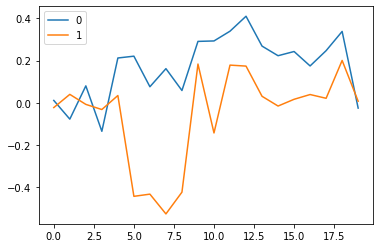

In [186]:
pd.DataFrame(w).plot()

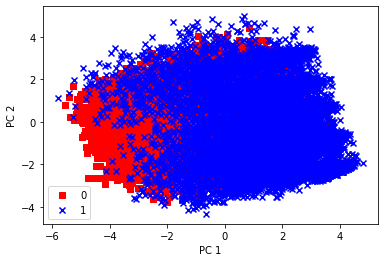

In [165]:
X_pca = X_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y), colors, markers):
    plt.scatter(X_pca[y==l, 0], 
                X_pca[y==l, 1], 
                c=c, label=l, marker=m) 
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

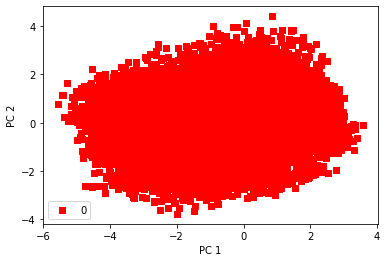

In [166]:
plt.scatter(X_pca[y==0, 0], 
                X_pca[y==0, 1], 
                c='r', label=0, marker='s') 
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

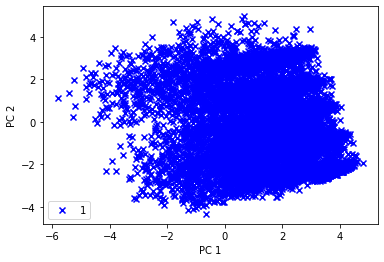

In [167]:
plt.scatter(X_pca[y==1, 0], 
                X_pca[y==1, 1], 
                c='b', label=1, marker='x') 
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

# ICA

In [124]:
from sklearn.decomposition import FastICA

transformer = FastICA(n_components=2,
        random_state=0,
        whiten='unit-variance')
X_transformed = transformer.fit_transform(X)
X_transformed.shape

(25976, 2)

<AxesSubplot:xlabel='ica1', ylabel='ica2'>

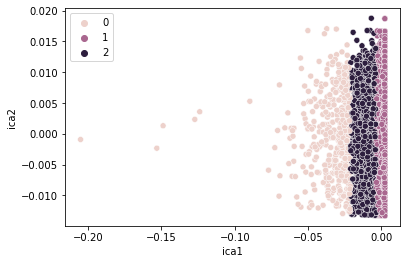

In [144]:
ica_data = pd.DataFrame(X_transformed, columns = ['ica1','ica2'])
sns.scatterplot(x='ica1', y='ica2', hue = y_km, data=ica_data)


# Random Projection (RP)

In [145]:
from sklearn import random_projection

rp = random_projection.GaussianRandomProjection(n_components = 2, random_state = 0 )
X_rp = rp.fit_transform(X)
X_rp.shape

(25976, 2)

<AxesSubplot:xlabel='rp1', ylabel='rp2'>

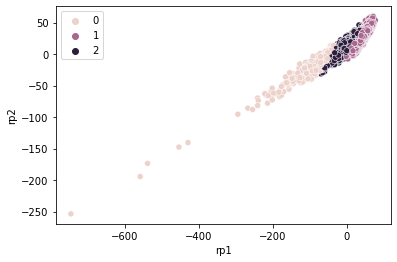

In [148]:
rp_data = pd.DataFrame(X_rp, columns = ['rp1','rp2'])
sns.scatterplot(x='rp1', y='rp2', hue = y_km, data=rp_data)
